In [275]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

from utils.network import Sequential
import random

from gym.vector import SyncVectorEnv


In [276]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [277]:
# Hyperparameters
max_timesteps = 3000
n_epochs = 10
learning_rate = 0.0003
gamma = 0.99
eps_clip = 0.2
K_epochs = 4
action_std = 0.5
batch_size = 64
update_timestep = 2000

beta = 0.0

BEHAVIOR_DIM = 5

In [278]:
def compute_gae(done, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert len(values) == len(next_values) == len(rewards) == len(done)

    advantages = torch.zeros(done.shape[0], dtype=torch.float32)
    returns = torch.zeros(done.shape[0], dtype=torch.float32)
    last_advantage = 0
    last_return = 0

    for t in reversed(range(done.shape[0])):
        mask = 1.0 - done[t]
        last_value = next_values[t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[t] + gamma * last_value - values[t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[t] + gamma * last_return

        advantages[t] = last_advantage
        returns[t] = last_return

    return advantages, returns

In [279]:
class Linear(nn.Module):
    def __init__(self, n_anchors, in_channels, out_channels, bias = True, same_init = False):
        super().__init__()
        self.n_anchors = n_anchors
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_bias = bias

        if same_init:
            anchor = nn.Linear(in_channels,out_channels,bias=self.is_bias)
            anchors = [copy.deepcopy(anchor) for _ in range(n_anchors)]
        else:
            anchors = [nn.Linear(in_channels,out_channels,bias=self.is_bias) for _ in range(n_anchors)]
        self.anchors = nn.ModuleList(anchors)

    def forward(self, x, alpha):
        
        xs = [anchor(x) for anchor in self.anchors]
        xs = torch.stack(xs,dim=-1)

        # alpha = torch.stack([alpha] * self.out_channels, dim=-2)
        # print(xs.shape, alpha.shape)
        alpha = alpha.unsqueeze(1).repeat(1, self.out_channels, 1)
        # print(xs.shape, alpha.shape)
        # print(xs.shape, alpha.shape, self.out_channels)
        # [8, 256, 2] [256, 2]
        xs = (xs * alpha).sum(-1)
        return xs
    
    
    
class Sequential(nn.Sequential):
    def __init__(self,*args):
        super().__init__(*args)

    def forward(self, input, t):
        # print(input.shape, t.shape)
        for module in self:
            input = module(input,t) if isinstance(module,Linear) else module(input)
        return input


class ActorCriticContinuous(nn.Module):
    def __init__(self, n_anchors, state_dim, action_dim, same_init, actor_hidden_layers, critic_hidden_layers, action_std):
        super(ActorCriticContinuous, self).__init__()
        
        # Define actor network
        actor_layers = []
        input_dim = state_dim
        for hidden_dim in actor_hidden_layers:
            actor_layers.append(Linear(n_anchors, input_dim, hidden_dim, same_init=same_init))
            actor_layers.append(nn.ReLU())
            input_dim = hidden_dim
        actor_layers.append(Linear(n_anchors, input_dim, action_dim, same_init=same_init))
        actor_layers.append(nn.Tanh())
        self.actor = Sequential(*actor_layers)
        self.n_anchors = n_anchors
        
        # Define critic network
        critic_layers = []
        input_dim = state_dim
        for hidden_dim in critic_hidden_layers:
            critic_layers.append(nn.Linear(input_dim, hidden_dim))
            critic_layers.append(nn.ReLU())
            input_dim = hidden_dim
        critic_layers.append(nn.Linear(input_dim, 1))
        self.critic = nn.Sequential(*critic_layers)
        
        self.action_var = nn.Parameter(torch.full((action_dim,), action_std**2, requires_grad=True))


    def forward(self, x, alpha, action=None):
        # print(f"{alpha.shape=}")
        action_mean = self.actor(x, alpha)
        cov_matrix = torch.exp(self.action_var)
        dist = Normal(loc=action_mean, scale=cov_matrix)
        
        if action is None:
            action = dist.sample()
            
        log_p = dist.log_prob(action).sum(dim=-1)
        
        value = self.critic(x)
        
        return action, action_mean, log_p, value, dist.entropy()
    
    
    def cosine_similarity(self,i,j):
        assert (i < self.n_anchors) and (j < self.n_anchors), "index higher than n_anchors"
        cos_sim = torch.Tensor([0.]).to(device)
        n = 0
        for module in self.actor:
            if isinstance(module,Linear):
                w1 = module.anchors[i].weight
                w2 = module.anchors[j].weight
                p1 = ((w1 * w2).sum() / max(((w1 ** 2).sum().sqrt() * (w2 ** 2).sum().sqrt()),1e-8)) ** 2
                b1 = module.anchors[i].bias
                b2 = module.anchors[j].bias
                p2 = ((b1 * b2).sum() / max(((b1 ** 2).sum().sqrt() * (b2 ** 2).sum().sqrt()),1e-8)) ** 2
                cos_sim += p1 + p2
                n += 2
        return cos_sim / n

In [280]:
class ConditionedActorCriticContinuous(nn.Module):
    def __init__(self, n_anchors, state_dim, action_dim, same_init, actor_hidden_layers, critic_hidden_layers, action_std):
        super(ConditionedActorCriticContinuous, self).__init__()
        
        # Define actor network
        actor_layers = []
        input_dim = state_dim + n_anchors
        for hidden_dim in actor_hidden_layers:
            actor_layers.append(nn.Linear(input_dim, hidden_dim))
            actor_layers.append(nn.ReLU())
            input_dim = hidden_dim
        actor_layers.append(nn.Linear(input_dim, action_dim))
        actor_layers.append(nn.Tanh())
        self.actor = nn.Sequential(*actor_layers)
        self.n_anchors = n_anchors
        
        # Define critic network
        critic_layers = []
        input_dim = state_dim + n_anchors
        for hidden_dim in critic_hidden_layers:
            critic_layers.append(nn.Linear(input_dim, hidden_dim))
            critic_layers.append(nn.ReLU())
            input_dim = hidden_dim
        critic_layers.append(nn.Linear(input_dim, 1))
        self.critic = nn.Sequential(*critic_layers)
        
        self.action_var = nn.Parameter(torch.full((action_dim,), action_std**2, requires_grad=True))


    def forward(self, obs, alpha, action=None):
        # print(f"{alpha.shape=}")
        x = torch.concat((obs, alpha), dim=-1)

        action_mean = self.actor(x)
        cov_matrix = torch.exp(self.action_var)
        dist = Normal(loc=action_mean, scale=cov_matrix)
        
        if action is None:
            action = dist.sample()
            
        log_p = dist.log_prob(action).sum(dim=-1)
        
        value = self.critic(x)
        
        return action, action_mean, log_p, value, dist.entropy()

In [281]:
class Discriminator(nn.Module):
    def __init__(self, layer_sizes):
        super(Discriminator, self).__init__()
        
        # Create a list of layers based on the provided layer_sizes
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # Add activation for hidden layers only
                layers.append(nn.ReLU())
        
        # Use nn.Sequential to combine the layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [282]:
def get_descriptor(info):
    d1 = np.mean([d1 for (d1, d2) in info])
    d2 = np.mean([d2 for (d1, d2) in info])
    return d1, d2
    # return np.mean(info['bfoot_touch_ground']), np.mean(info['ffoot_touch_ground'])
    
    
def get_descriptors_from_trajectories(data):
    
    num_envs = data['info'].shape[0]
    
    descriptors = []
    for n in range(num_envs):
        env_n_descriptors = []
        trajectory_info = []
        for i in range(len(data['info'][n])):
            # print(i)
            trajectory_info.append(data['info'][n][i])
            
            if data['done'][n][i] == True:
                d1, d2 = get_descriptor(trajectory_info)
                # d1, d2 = round(d1*BEHAVIOR_DIM), round(d2*BEHAVIOR_DIM)
                descriptors.append((d1, d2))
        
        # descriptors.append(env_n_descriptors)
        
    return descriptors




def descriptors_to_vectors(descriptors):
    vectors = []
    for (d1, d2) in descriptors:
        vector = [0]*(BEHAVIOR_DIM**2)
        vector[d1*BEHAVIOR_DIM+d2] = 1
        vectors.append(vector)
    return vectors

def descriptors_to_id(descriptors):
    ids = []
    for (d1, d2) in descriptors:
        ids.append(d1*BEHAVIOR_DIM+d2)
    return ids

In [283]:
def random_alpha(n, n_anchors):
    random_probs = torch.rand(n, n_anchors)
    proba_vector = random_probs / random_probs.sum(dim=1, keepdim=True)
    return proba_vector

In [284]:
def compute_diversity_reward(model, alpha, states):
    

    # print(f'{alpha.shape=:}')
    
    n_anchors = model.n_anchors
    
    num_envs, n_steps, state_dim = states.shape

    d_alpha = alpha.unsqueeze(1).repeat(1, n_steps, 1)
    d_states = states.to(device)
    

    # action, action_mean, log_p, state_value, entropy = model(d_states.reshape(-1, 17), d_alpha.reshape(-1, 2))
    # action_mean = action_mean.reshape(num_envs, n_steps, -1) # (alpha, state, action)
    
    # print(f'{d_alpha.shape=:} {d_states.shape=:}')
    
    diversity_reward = torch.zeros((num_envs, n_steps), dtype=torch.float32)
    
    for alpha_i in range(num_envs):
        
        d_states = states[alpha_i]
        d_states = d_states.unsqueeze(0).repeat(num_envs, 1, 1).to(device) # (alpha, n_steps, state)
        
        d_alpha = alpha.unsqueeze(1).repeat(1, n_steps, 1) # (alpha, n_steps, n_anchors)
        
        with torch.no_grad():
            action, action_mean, log_p, state_value, entropy = model(d_states.reshape(-1, 17), d_alpha.reshape(-1, n_anchors))
        action_mean = action_mean.reshape(num_envs, n_steps, -1).cpu() # (alpha, n_steps, action)
        # print(f'{d_alpha.shape=:} {d_states.shape=:} {action_mean.shape=:}')
        
        for s in range(n_steps):
            count = 0
            
            for alpha_j in range(num_envs):
                if alpha_i != alpha_j:
                    diversity_reward[alpha_i, s] += ((action_mean[alpha_i, s] - action_mean[alpha_j, s])**2).sum()
                    count += 1
                    
            diversity_reward[alpha_i, s] /= count

    # diversity_value = diversity_value / count
    # print(diversity_reward.shape)
    # for i in range
    return diversity_reward

In [285]:
# trajectory, info = collect_trajectories(env, model, discriminator, alpha, n_steps=max_episode_steps)

In [286]:




def collect_trajectories(env, model, discriminator: Discriminator, alpha: torch.tensor, n_steps: int):
    
    states = np.zeros((env.num_envs, n_steps, env.single_observation_space.shape[0]), dtype=np.float32)
    actions = np.zeros((env.num_envs, n_steps, env.single_action_space.shape[0]), dtype=np.float32)
    rewards = np.zeros((env.num_envs, n_steps), dtype=np.float32)
    log_ps = np.zeros((env.num_envs, n_steps), dtype=np.float32)
    state_values = np.zeros((env.num_envs, n_steps), dtype=np.float32)
    dones = np.zeros((env.num_envs, n_steps), dtype=np.float32)
    info = np.zeros((env.num_envs, n_steps, 2), dtype=np.float32)
    
    advantages = np.zeros((env.num_envs, n_steps), dtype=np.float32)

    state, _ = env.reset()
    

    total_reward = 0
    step_count = 0

    for s in range(n_steps):
        state = torch.FloatTensor(state).to(device)
        # print(state.shape, alpha.shape)
        with torch.no_grad():
            action, action_mean, log_p, state_value, entropy = model(state, alpha)
        next_state, reward, terminated, truncated, _ = env.step(action.cpu().tolist())
        done = (terminated | truncated)
        
        states[:, s] = state.cpu()
        actions[:, s] = action.cpu()
        rewards[:, s] = reward
        log_ps[:, s] = log_p.cpu().detach().numpy()
        state_values[:, s] = state_value.cpu().detach().reshape(-1).numpy()
        dones[:, s] = done
        info[:, s] = [(int(5 in env_.data.contact.geom2), int(8 in env_.data.contact.geom2)) for env_ in env.envs]        

        state = next_state
        # total_reward += reward
        # step_count += 1

        if done.any():
            # state, _ = env.reset(np.where(dones)[0])
            state, _ = env.reset()
    
    
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Discriminator reward:
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # descriptors = descriptors_to_id(get_descriptors_from_trajectories({'info': info, 'done': dones}))
    # descriptors = torch.tensor(descriptors).to(device)
    
    # with torch.no_grad():
    #     probs = torch.softmax(discriminator(alpha), dim=-1)
        
    # prob_d_a = probs.gather(1, descriptors.unsqueeze(1)).reshape(-1)
    # prob_d_a_rewards = prob_d_a.unsqueeze(1).repeat(1, 1000).cpu().numpy()
    # rewards = prob_d_a_rewards
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    descriptors = get_descriptors_from_trajectories({'info': info, 'done': dones})
    descriptors = torch.tensor(descriptors).to(device)
    
    # rewards = ((BEHAVIOR_DIM-1) - abs((alpha[:, 0]*BEHAVIOR_DIM).int() - 1))/(BEHAVIOR_DIM-1)
    # rewards = ((BEHAVIOR_DIM-1) - abs(descriptors - torch.tensor((1., 1.)).to(device))) / (BEHAVIOR_DIM-1)
    # print(descriptors)
    # rewards = - torch.norm(descriptors - torch.tensor((1., 1.)).to(device), dim=1)
    # rewards = rewards.unsqueeze(1).repeat(1, 1000).cpu().numpy()
    # print(descriptors)
    # print(rewards)
    # tmp = torch.zeros((env.num_envs, n_steps), dtype=torch.float32)
    # print(rewards)
    # tmp[:, -1] = rewards
    # rewards = tmp
    
    # print(rewards)
    
    
    # rewards = torch.tensor(info).sum(dim=2).float()
    # rewards = torch.tensor(info)[..., 0].float()
    # print(rewards)
    
    
    critic_x = torch.concat((torch.FloatTensor(next_state).to(device), alpha), dim=-1)
    next_value = model.critic(critic_x).cpu()    
    
        
    states = torch.tensor(states)
    actions = torch.tensor(actions)
    rewards = torch.tensor(rewards)
    # rewards = rewards * compute_diversity_reward(model, alpha, states)
    
    log_ps = torch.tensor(log_ps)
    state_values = torch.tensor(state_values)
    dones = torch.tensor(dones)
    next_state_values = torch.concatenate((state_values[:, 1:], next_value), dim=-1)
    

    advantages, returns = [], []
    for i in range(env.num_envs):
        a, r = compute_gae(dones[i], rewards[i], state_values[i], next_state_values[i])
        advantages.append(a)
        returns.append(r)
    advantages = torch.stack(advantages)
    returns = torch.stack(returns)

    
    trajectories = {
        "alphas": alpha.unsqueeze(1).repeat(1, n_steps, 1).reshape(-1, model.n_anchors),
        "states" :  states.reshape(-1, env.single_observation_space.shape[0]).detach(),
        "actions" : actions.reshape(-1, env.single_action_space.shape[0]).detach(),
        "rewards" : rewards.reshape(-1).detach(),
        "dones" : dones.reshape(-1).detach(),
        "log_ps" : log_ps.reshape(-1).detach(),
        "state_values": state_values.reshape(-1).detach(),
        "next_state_values": next_state_values.reshape(-1).detach(),
        "returns" : returns.reshape(-1).detach(),
        "advantages" : advantages.reshape(-1).detach(),
    }

    return trajectories, {'info':info, 'done':dones, 'reward': rewards}


def shufffle_trajectory(trajectories):
    length = trajectories['states'].shape[0]
    permutation = torch.randperm(length)

    shuffled_trajectories = {key: tensor[permutation] for key, tensor in trajectories.items()}
    return shuffled_trajectories

In [287]:
# trajectory, info = collect_trajectories(env, model, discriminator, alpha, n_steps=max_episode_steps)

In [288]:
def compute_diversity_loss(model, states, num_alpha=8):
    
    batch_size = states.shape[0]

    alpha = random_alpha(num_alpha, model.n_anchors).to(device)
    d_alpha = alpha.unsqueeze(0).repeat(batch_size, 1, 1)

    d_states = states.unsqueeze(1).repeat(1, num_alpha, 1)

    action, action_mean, log_p, state_value, entropy = model(d_states.reshape(-1, 17), d_alpha.reshape(-1, 2))
    action_mean = action_mean.reshape(batch_size, num_alpha, -1) # (state, alpha, action)

    state_alpha_alpha_mat = ((action_mean[:, :, None, :] - action_mean[:, None, :, :])**2).sum(dim=(-1))
    for i in range(num_alpha): state_alpha_alpha_mat[:, i, i] = 0

    state_diversity = state_alpha_alpha_mat.sum(dim=(-1, -2)) / (num_alpha*(num_alpha-1))
    diversity_loss = state_diversity.mean()
    return diversity_loss



def ppo_optimization(trajectories, model, optimizer, epochs, batch_size):
    
    model.train()
    
    traj_alphas = trajectories["alphas"]
    traj_states = trajectories["states"]
    traj_actions = trajectories["actions"]
    traj_log_ps = trajectories["log_ps"]
    traj_returns = trajectories["returns"]  
    traj_advantages = trajectories["advantages"]


    len_trajectory = traj_states.shape[0]

    for epoch in range(1, epochs+1):
        for i in range(len_trajectory // batch_size):
            alpha = traj_alphas[batch_size*i:batch_size*(i+1)].to(device)
            state = traj_states[batch_size*i:batch_size*(i+1)].to(device)
            action = traj_actions[batch_size*i:batch_size*(i+1)].to(device)
            log_p = traj_log_ps[batch_size*i:batch_size*(i+1)].to(device)
            return_ = traj_returns[batch_size*i:batch_size*(i+1)].to(device)
            advantage = traj_advantages[batch_size*i:batch_size*(i+1)].to(device)
                        
            # print(alpha)
            new_action, new_action_mean, new_log_p, new_state_value, entropy = model(state, alpha, action)
            assert(new_action == action).all()
            
            
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

            new_log_p, log_p, advantage = new_log_p.reshape(-1), log_p.reshape(-1), advantage.reshape(-1)
            
            ratio = torch.exp(new_log_p - log_p.detach())
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            policy_loss = - torch.min(surr1, surr2).mean()
            
            # print(policy_loss)
            
            
            return_, new_state_value = return_.reshape(-1), new_state_value.reshape(-1)
            critic_loss = ((return_ - new_state_value)**2).mean()
            
            penalty = 0
            diversity_loss = torch.tensor([0.])
            # if model.n_anchors > 1:
            #     j,k = random.sample(range(model.n_anchors),2)
            #     penalty = model.cosine_similarity(j,k)
            
                # diversity_loss = compute_diversity_loss(model, state, num_alpha=8)

            # loss = policy_loss - 2e-7*entropy.mean() + 0.5*critic_loss + beta*penalty - 0.01*diversity_loss
            loss = policy_loss - 2e-7*entropy.mean() + 0.5*critic_loss + beta*penalty

            optimizer.zero_grad()
            loss.backward()
            clip_factor = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
    
    return diversity_loss.item()
# ppo_optimization(trajectories, model, optimizer, epochs=1, batch_size=5)
# ppo_optimization(shuffled_trajectory, model, alpha, optimizer, epochs=5, batch_size=256)

In [289]:
def evaluate(env, model, alpha):
    model.eval()

    state, _ = env.reset()
        
    total_reward = 0
    step_count = 0

    trajectory = []
    info = []
    

    while True:
        trajectory.append(state)
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            action, mean_action, log_p, state_value, entropy = model(state, alpha)
        next_state, reward, terminated, truncated, _ = env.step(action[0].cpu().tolist())

        info.append((
            int(5 in env.data.contact.geom2), int(8 in env.data.contact.geom2)
        ))
        
        done = terminated or truncated

        state = next_state
        total_reward += reward
        step_count += 1
        
        
        if done:
            break
        
    return total_reward, trajectory, info


def get_reward_from_trajectory(info):
    save_ = []
    acc_reward = 0
    for n in range(len(info['reward'])):
        for i in range(len(info['reward'][n])):
            if info['done'][n][i] == True:
                save_.append(acc_reward)
                acc_reward = 0
            
            acc_reward += info['reward'][n][i]
    return np.mean(save_)

In [290]:
# env = gym.vector.make('HalfCheetah-v4', render_mode = "rgb_array", num_envs=8)

max_episode_steps = 1000
num_envs = 8
env_fns = [lambda: gym.make('HalfCheetah-v4', render_mode="rgb_array", max_episode_steps=max_episode_steps) for _ in range(num_envs)]
env = gym.vector.SyncVectorEnv(env_fns)

n_anchors = 2
state_dim = env.observation_space.shape[-1]
action_dim = env.action_space.shape[-1]


In [291]:
model = ConditionedActorCriticContinuous(
    n_anchors,
    state_dim,
    action_dim,
    same_init=False,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)


discriminator = Discriminator([n_anchors, 256, BEHAVIOR_DIM**2]).to(device)
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=0.01)


rewards = []
all_descriptors = []
all_alphas = []

H_d_a_list = []
H_d_list = []
cross_entropies = []
diversity_lossses = []

tqdm_epochs = tqdm(range(1, 2000+1))
for epochs in tqdm_epochs:
    
    for _ in range(1):
        alpha = random_alpha(env.num_envs, n_anchors).to(device)
        trajectory, info = collect_trajectories(env, model, discriminator, alpha, n_steps=max_episode_steps)
        descriptors = get_descriptors_from_trajectories(info)
        
        all_alphas += alpha.tolist()
        all_descriptors += descriptors
        print(descriptors)
    
    
    if epochs % 2 == -1:
        
        d = torch.tensor(descriptors_to_id(all_descriptors), dtype=torch.long).to(device)
        a = torch.tensor(all_alphas, dtype=torch.float32).to(device)
        pred_d = discriminator(a)


        probs = torch.softmax(pred_d, dim=-1)
        dist = torch.distributions.Categorical(probs=probs)
        H_d_a = dist.entropy().mean()
        
        log_prob_d_a = torch.log(probs.gather(1, d.unsqueeze(1))).mean()
        

        prob_d = probs.mean(dim=0)
        dist = torch.distributions.Categorical(probs=prob_d)
        H_d = dist.entropy()
        
        
        # loss = H_d_a - 4*H_d
        loss = - log_prob_d_a - 10*H_d
        
        disc_optim.zero_grad()
        loss.backward()
        disc_optim.step()
        
        H_d_a_list.append(H_d_a.item())
        H_d_list.append(H_d.item())
        cross_entropies.append(-log_prob_d_a.item())
        
        all_descriptors = []
        all_alphas = []
        
        print(prob_d)
        # print(d)
        
    
    shuffled_trajectory = shufffle_trajectory(trajectory)
    diversity_loss = ppo_optimization(shuffled_trajectory, model, optimizer, epochs=4, batch_size=512)
    diversity_lossses.append(diversity_loss)
    
    # final_reward = np.mean([evaluate(env, model, random_alpha(n_anchors).to(device))[0] for _ in range(1)])
    final_reward = get_reward_from_trajectory(info)
    rewards.append(max(final_reward, -3000))
    
    tqdm_epochs.set_description(f'Reward: {final_reward:.2f}')
    
    
    if epochs % 10 == 0:
        clear_output(True)
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].plot(rewards)
        axes[0].set_title('Rewards')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Reward')

        # axes[1].plot(H_d_list, label='H(d)')
        # axes[1].plot(H_d_a_list, label='H(d|a)')
        # axes[1].plot(cross_entropies, label='-log(d|a)')
        axes[1].plot(diversity_lossses, label='diversity_losss')
        # axes[1].set_title('H_d_list and H_d_a_list')
        # axes[1].set_xlabel('Epoch')
        # axes[1].set_ylabel('Value')
        # axes[1].legend()

        # Display the plots
        plt.tight_layout()
        plt.show()

Reward: -1175.31:   0%|          | 1/2000 [00:01<51:18,  1.54s/it]

[(0.071, 0.15), (0.04, 0.102), (0.033, 0.138), (0.108, 0.278), (0.124, 0.25), (0.004, 0.036), (0.091, 0.286), (0.028, 0.041)]


Reward: -1105.18:   0%|          | 2/2000 [00:03<51:39,  1.55s/it]

[(0.116, 0.273), (0.016, 0.055), (0.056, 0.237), (0.035, 0.111), (0.047, 0.115), (0.044, 0.108), (0.009, 0.027), (0.071, 0.118)]


Reward: -1118.09:   0%|          | 3/2000 [00:04<50:26,  1.52s/it]

[(0.057, 0.1), (0.088, 0.224), (0.093, 0.264), (0.013, 0.033), (0.02, 0.029), (0.003, 0.007), (0.079, 0.128), (0.032, 0.069)]


Reward: -1079.31:   0%|          | 4/2000 [00:06<50:01,  1.50s/it]

[(0.036, 0.088), (0.047, 0.09), (0.014, 0.045), (0.01, 0.025), (0.016, 0.024), (0.088, 0.175), (0.006, 0.032), (0.025, 0.057)]


Reward: -1079.31:   0%|          | 4/2000 [00:07<1:01:24,  1.85s/it]


KeyboardInterrupt: 

---

In [ ]:
# model = ActorCriticContinuous(
#     1,
#     state_dim,
#     action_dim,
#     same_init=True,
#     actor_hidden_layers=[256, 256],
#     critic_hidden_layers=[256, 256],
#     action_std=0.5
# ).to(device)

# model.load_state_dict(torch.load('models/halfcheetah/n_anchors=1.pt'))

/tmpdata/ipykernel_872636/1171200678.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/halfcheetah/n_anchors=1.pt'))


<All keys matched successfully>

In [ ]:
random_alpha(1, n_anchors)

tensor([[0.7396, 0.2604]])

In [ ]:
single_env = gym.make('HalfCheetah-v4', render_mode="rgb_array", max_episode_steps=max_episode_steps)

descriptors = []
desc_rewards = []

for _ in tqdm(range(100)):
    reward, states, info = evaluate(single_env, model, random_alpha(1, n_anchors).to(device))
    descriptors.append(get_descriptor(info))
    rewards.append(reward)
    
descriptors_array = np.array(descriptors)

  0%|          | 0/100 [00:00<?, ?it/s]/home/nazim/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


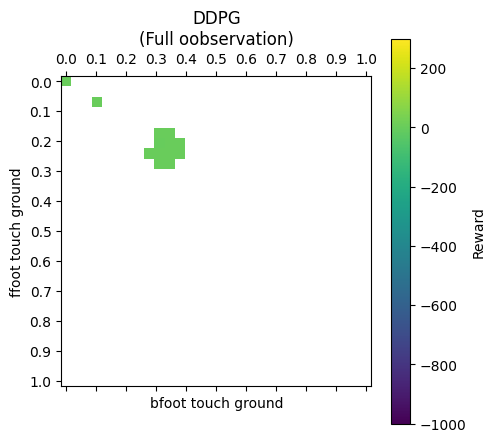

In [ ]:
import matplotlib.pyplot as plt

x1, x2 = 0, 1

x1_min = 0
x1_max = 1
x2_min = 0
x2_max = 1

N = 30

x1_bins = np.linspace(x1_min, x1_max, N)
x2_bins = np.linspace(x2_min, x2_max, N)

map_grid = np.full((N, N), np.nan)


def get_bin(value, bins):
    return np.digitize(value, bins) - 1


for descriptor, reward in zip(descriptors, rewards):
    feature1, feature2 = descriptor[x1], descriptor[x2]
    f1_bin = get_bin(feature1, x1_bins)
    f2_bin = get_bin(feature2, x2_bins)
    
    if np.isnan(map_grid[f1_bin, f2_bin]):
        map_grid[f1_bin][f2_bin] = reward
    else:
        map_grid[f1_bin][f2_bin] = max(map_grid[f1_bin][f2_bin], reward) 


fig, axs = plt.subplots(1, 1, figsize=(5,5))


cax = axs.matshow(map_grid, cmap="viridis", vmin=-1000, vmax=300)
axs.set_title('DDPG\n(Full oobservation)', loc='center')

axs.set_xlabel('bfoot touch ground')
axs.set_ylabel('ffoot touch ground')
axs.set_xticks(np.linspace(0, N-1, num=11))
axs.set_xticklabels(np.round(np.linspace(0, 1, num=11), 2))
axs.set_yticks(np.linspace(0, N-1, num=11))
axs.set_yticklabels(np.round(np.linspace(0, 1, num=11), 2))
    
fig.colorbar(cax, ax=axs, orientation='vertical', label='Reward')
plt.show()

In [ ]:
model = ActorCriticContinuous(
    1,
    state_dim,
    action_dim,
    same_init=False,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)

model.load_state_dict(torch.load('models/halfcheetah/n_anchors=1.pt'))


<All keys matched successfully>

In [ ]:
import gym

In [ ]:
one_env = gym.make('HalfCheetah-v4', render_mode="rgb_array", max_episode_steps=100)

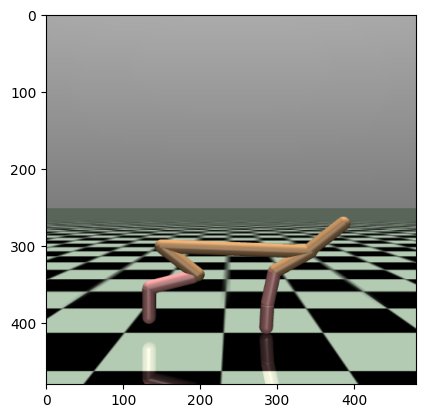

  3%|▎         | 99/3000 [00:08<04:02, 11.95it/s]

False True
-2945.8035999225435


In [ ]:
from time import sleep

alpha = torch.tensor([0.5.]).to(device)

state, _ = one_env.reset()
total_reward = 0
tqdm_range = tqdm(range(max_timesteps))
for t in tqdm_range:
    state = torch.FloatTensor(state).to(device)
    with torch.no_grad():
        action, log_p, state_value, entropy = model(state, alpha)
    # action = torch.normal(0, 1, size=(action.shape))
    next_state, reward, terminated, truncated, _ = one_env.step(action[0].cpu().tolist())
    done = terminated or truncated
    
    # Add data to memory
    # memory.add(state, action, reward, action_logprob, done)
    state = next_state
    total_reward += reward
    
    clear_output(True)
    frame = one_env.render()
    plt.imshow(frame)
    plt.show()
    
    # print(env.get_body_com('ffoot'))
    # print(env.data.body('bfoot').cfrc_int, env.data.body('ffoot').cfrc_int)
    
    
    # print(env.data.body('ffoot').xipos)
    # print(env.data.body('bfoot').cfrc_ext.any(), env.data.body('ffoot').cfrc_ext.any())
    # print(env.data.contact)
    print(5 in one_env.data.contact.geom2, 8 in one_env.data.contact.geom2)
    
    # if env.data.contact.H.shape[0] != 0:
        # break
    
    if done:
        break
    
    # sleep(1)
    
print(total_reward)

In [ ]:
env.data.contact.geom2

array([5, 8], dtype=int32)

In [ ]:
env.data.body

<bound method PyCapsule.body of <mujoco._structs.MjData object at 0x754a173cd070>>

In [ ]:
env.data.body('ffoot').cfrc_int

array([  0.        ,  22.1293691 ,   0.        , -52.90674133,
         0.        , -13.8416032 ])

In [ ]:
env.data.body('bfoot').cfrc_int

array([  0.        , -65.58391056,   0.        , 124.25011867,
         0.        , -41.76418074])

In [ ]:
env.data.body('bfoot')

<_MjDataBodyViews
  cacc: array([   0.        , -731.05017666,    0.        ,  -51.67292521,
          0.        ,  575.00922327])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([  0.        , -65.58391056,   0.        , 124.25011867,
         0.        , -41.76418074])
  cinert: array([ 0.05770359,  0.76445357,  0.70785189,  0.        , -0.19661607,
        0.        , -0.87857201,  0.        , -0.24193659,  1.09539749])
  crb: array([ 0.05770359,  0.76445357,  0.70785189,  0.        , -0.19661607,
        0.        , -0.87857201,  0.        , -0.24193659,  1.09539749])
  cvel: array([ 0.        ,  7.11009233,  0.        ,  5.33851089,  0.        ,
       -5.19108022])
  id: 4
  name: 'bfoot'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([2.04672575, 0.        , 0.42603072])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([ 0.77652312,  0.        ,  0.63008876,  0.        ,  1.        ,
        0.        

In [ ]:
from datetime import datetime
now = datetime.now()
formatted_time = now.strftime("%d/%m/%Y-%H:%M:%S")
formatted_time

'03/11/2024-21:15:50'

In [ ]:
datetime.now

AttributeError: module 'datetime' has no attribute 'now'